## Rhexis limbus detection - edge cases
When detecting limbus on the plain rhexis eye model there are edge cases when the naive approach fails. This is exploration of extensions to the original pipeline to achieve more robustness.

### 1. Imports

In [13]:
import time

import cv2
import numpy as np
from matplotlib import pyplot as plt

from helpers.limbus_detection import detect_pupil_thresh
from helpers.view_detection import get_view_mask


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


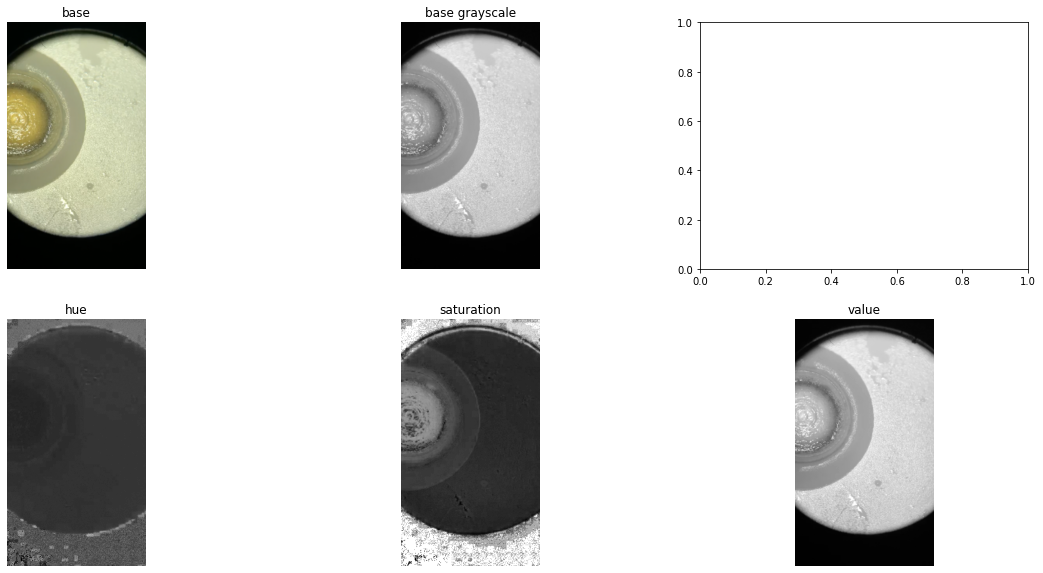

size: 233x417


In [14]:
scale = 0.33

base = cv2.imread('data/artificial/bioniko_rhexis_base5.png', cv2.IMREAD_COLOR)
base = cv2.resize(base, (0, 0), fx=scale, fy=scale)

base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:, :, 0]
base_saturation = base_hsv[:, :, 1]
base_value = base_hsv[:, :, 2]

fig, ((plot1, plot2, _), (plot3, plot4, plot5)
      ) = plt.subplots(2, 3, figsize=(20, 10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

print('size: %dx%d' % (base.shape[1], base.shape[0]))

### 2. Plain detection without any additional treatment
Naive detection relies on image moments calculation. When only a part of the circle is visible we introduce a considerable bias this way. And the final detection is not centered correctly and/or has incorrect radius size.

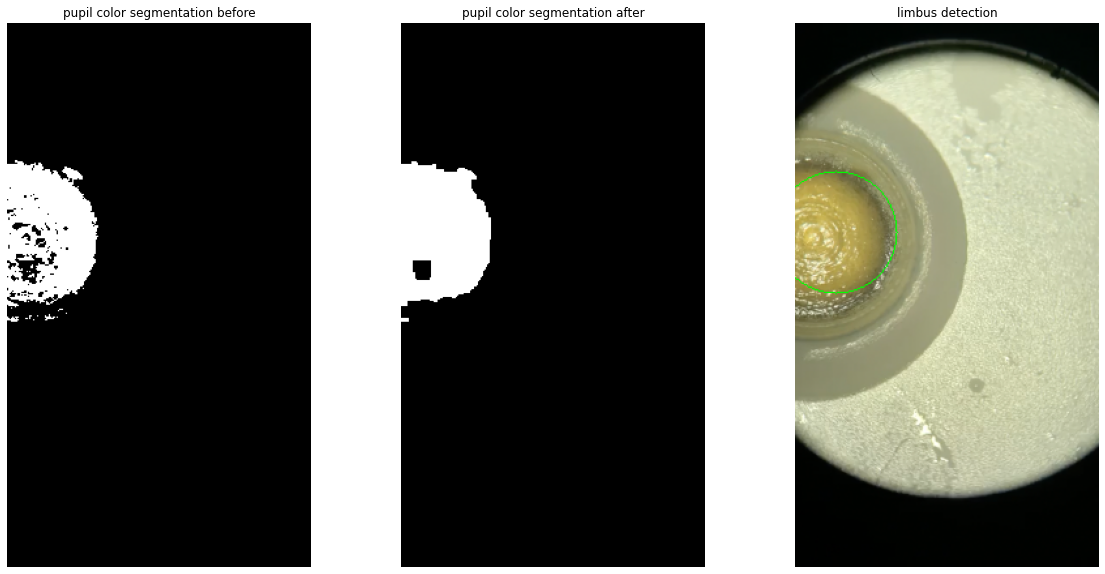

In [15]:
# color thresholding
pupil_color_lth = np.array([15, 100, 50])
pupil_color_uth = np.array([30, 200, 255])

base_pupil_thres = cv2.inRange(base_hsv, pupil_color_lth, pupil_color_uth)

# morphological processing
# size of kernel could be automatically set based on image moments
kernel = np.ones((3, 3), np.uint8)

base_pupil_thres_copy = base_pupil_thres.copy()
base_pupil_thres_copy = cv2.morphologyEx(
    base_pupil_thres_copy, cv2.MORPH_OPEN, kernel)
base_pupil_thres_copy = cv2.morphologyEx(
    base_pupil_thres_copy, cv2.MORPH_CLOSE, kernel, iterations=3)

# image moments calculation
moments = cv2.moments(base_pupil_thres_copy, binaryImage=True)
center = (round(moments['m10']/moments['m00']),
          round(moments['m01']/moments['m00']))
std_est = np.sqrt(moments['mu20']/moments['m00']) + \
    np.sqrt(moments['mu02']/moments['m00'])
std_est /= 2
radius = round(2*std_est)

base_copy = base_rgb.copy()
cv2.circle(base_copy, center, radius, (0, 255, 0))

# visualization
fig, plots = plt.subplots(1, 3, figsize=(20, 10))
plots[0].set_title('pupil color segmentation before')
plots[0].imshow(base_pupil_thres, cmap='gray')
plots[0].axis('off')

plots[1].set_title('pupil color segmentation after')
plots[1].imshow(base_pupil_thres_copy, cmap='gray')
plots[1].axis('off')

plots[2].set_title('limbus detection')
plots[2].imshow(base_copy)
plots[2].axis('off')

plt.show()

### 3. PCA-based correction
We can substitute image moments with PCA. This way we can better get the sense of directionality. That is, we can determine the direction of highest variance, which should correspond to the full diameter of the eye. And thus, we make corrections in post-processing. However, this assumes that at least half of the eye is visible in the view. Also, we still heavily rely on somewhat accurate color thresholding in pre-processing.

In [16]:
start = time.time()

points = np.array((
    np.where(base_pupil_thres_copy == 255)[1],
    np.where(base_pupil_thres_copy == 255)[0])).T
points = points.astype(np.float32)
mean = np.empty((0))
mean, eigenvectors, eigenvalues = cv2.PCACompute2(points, mean)
mean = mean[0]

end = time.time()

print('runtime: %f ms' % (1000*(end - start)))
print('centroid: %s' % str(mean))
print()
print('primary eigenvector: %s' % str(eigenvectors[0]))
print('secondary eigenvector: %s' % str(eigenvectors[1]))
print('eigenvalues: %s' % str(eigenvalues.T[0]))

runtime: 2.509117 ms
centroid: [ 30.77785 160.25505]

primary eigenvector: [0.04385362 0.9990379 ]
secondary eigenvector: [ 0.9990379  -0.04385362]
eigenvalues: [804.75336 350.76486]


Correction

In [17]:
# mean shift computation
mean_shift_scale = 2*(np.sqrt(eigenvalues[0][0]) - np.sqrt(eigenvalues[1][0]))
mean_shift = mean_shift_scale*eigenvectors[1]

# determining correct sign
image_center = np.array(
    (base_rgb.shape[1], base_rgb.shape[0]), dtype=np.float32)/2
mean_corrected1 = mean - mean_shift
mean_corrected2 = mean + mean_shift

mean_corrected = None
if np.linalg.norm(mean_corrected1 - image_center) > np.linalg.norm(mean_corrected2 - image_center):
    mean_corrected = mean_corrected1
else:
    mean_corrected = mean_corrected2

print('mean shift correction: %f' % mean_shift_scale)
print('corrected centroid: %s' % str(mean_corrected))

mean shift correction: 19.278915
corrected centroid: [ 11.517481 161.1005  ]


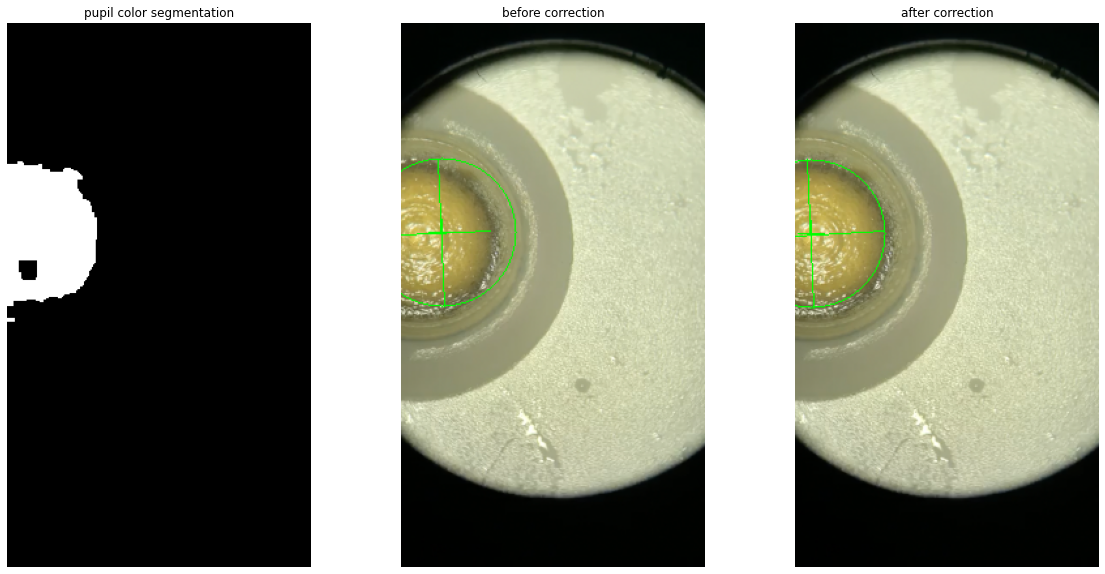

In [18]:
# before correction
base_copy_before = base_rgb.copy()
cv2.drawMarker(base_copy_before, tuple(
    mean.round().astype(np.int32)), (0, 255, 0))

scale = 2*np.sqrt(eigenvalues[0][0])
line_start = tuple((mean - scale*eigenvectors[0]).round().astype(np.int32))
line_end = tuple((mean + scale*eigenvectors[0]).round().astype(np.int32))
cv2.line(base_copy_before, line_start, line_end, (0, 255, 0))
cv2.circle(base_copy_before, tuple(
    mean.round().astype(np.int32)), round(scale), (0, 255, 0))

scale = 2*np.sqrt(eigenvalues[1][0])
line_start = tuple((mean - scale*eigenvectors[1]).round().astype(np.int32))
line_end = tuple((mean + scale*eigenvectors[1]).round().astype(np.int32))
cv2.line(base_copy_before, line_start, line_end, (0, 255, 0))

# after correction
base_copy_after = base_rgb.copy()
cv2.drawMarker(base_copy_after, tuple(
    mean_corrected.round().astype(np.int32)), (0, 255, 0))

scale = 2*np.sqrt(eigenvalues[0][0])
line_start = tuple(
    (mean_corrected - scale*eigenvectors[0]).round().astype(np.int32))
line_end = tuple(
    (mean_corrected + scale*eigenvectors[0]).round().astype(np.int32))
cv2.line(base_copy_after, line_start, line_end, (0, 255, 0))
cv2.circle(base_copy_after, tuple(
    mean_corrected.round().astype(np.int32)), round(scale), (0, 255, 0))

line_start = tuple(
    (mean_corrected - scale*eigenvectors[1]).round().astype(np.int32))
line_end = tuple(
    (mean_corrected + scale*eigenvectors[1]).round().astype(np.int32))
cv2.line(base_copy_after, line_start, line_end, (0, 255, 0))

# visualization
fig, plots = plt.subplots(1, 3, figsize=(20, 10))
plots[0].set_title('pupil color segmentation')
plots[0].imshow(base_pupil_thres_copy, cmap='gray')
plots[0].axis('off')

plots[1].set_title('before correction')
plots[1].imshow(base_copy_before)
plots[1].axis('off')

plots[2].set_title('after correction')
plots[2].imshow(base_copy_after, cmap='gray')
plots[2].axis('off')

plt.show()

### 4. Video demo

In [20]:
pupil_color_lth = np.array([15, 100, 50])
pupil_color_uth = np.array([30, 200, 255])

cap = cv2.VideoCapture('data/artificial/rhexis_input_long.mp4')
_, frame = cap.read()
view_mask, view_circle = get_view_mask(cv2.cvtColor(
    frame, cv2.COLOR_BGR2GRAY), return_circle=True)

while cap.isOpened():
    ret, frame = cap.read()

    # color threholding
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    pupil_thres = cv2.inRange(hsv, pupil_color_lth, pupil_color_uth)
    blended = cv2.addWeighted(
        frame,
        0.8,
        cv2.cvtColor(pupil_thres, cv2.COLOR_GRAY2BGR),
        0.5,
        0.0
    )

    # without correction
    timer = cv2.getTickCount()

    pupil_thres_mask = cv2.inRange(hsv, pupil_color_lth, pupil_color_uth)
    circle = detect_pupil_thresh(pupil_thres_mask)

    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    # with correction
    timer = cv2.getTickCount()

    pupil_thres_mask = cv2.inRange(hsv, pupil_color_lth, pupil_color_uth)
    circle_corrected = detect_pupil_thresh(
        pupil_thres_mask, pca_correction=True, pca_correction_ratio=0.7)

    fps_corrected = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    if circle is not None or circle_corrected is not None:
        if circle is not None:
            cv2.circle(frame, tuple(circle[:2].round().astype(np.int64)),
                       round(circle[2]), (0, 255, 0))
            cv2.putText(frame, 'without correction fps: %d' % round(fps),
                        (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                        (0, 255, 0), 1)

        if circle_corrected is not None:
            cv2.circle(frame, tuple(circle_corrected[:2].round().astype(np.int64)),
                       round(circle_corrected[2]), (255, 255, 0))
            cv2.putText(frame, 'with correction fps: %d' % round(fps_corrected),
                        (5, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                        (255, 255, 0), 1)
    else:
        cv2.putText(frame, 'detection failed',
                    (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                    (0, 0, 255), 1)

    cv2.imshow('blend', blended)
    cv2.imshow('thresholding', pupil_thres)
    cv2.imshow('detection', frame)

    if cv2.waitKey(25) == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)